# utils.data.Sampler

In [ ]:
# Getting toy dataset
!wget https://github.com/DeepStudio-TW/torch-dataloader-tutorial/raw/main/data.csv

In [1]:
import torch
import time
import pandas as pd
import torch.utils.data as tud
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NumDataset(tud.Dataset):
    def __init__(self,fname,number_length):
        super().__init__()
        self.df=pd.read_csv(fname).head(number_length)
        self.number_length=number_length
        
        self.data=self.df.data.values
        self.label=self.df.label.values
    def __len__(self):
        return self.number_length
    def __getitem__(self, idx):
        data=self.data[idx]
        label=self.label[idx]
        return data,label

In [3]:
dataset=NumDataset("data.csv",5)

## SequentialSampler

In [4]:
'''照順序sample dataset'''
seq_sampler=tud.SequentialSampler(dataset)

In [5]:
for idx in seq_sampler:
    print(idx)

0
1
2
3
4


In [6]:
'''Sampler是用在DataLoader上的'''
dataloader=tud.DataLoader(dataset,sampler=seq_sampler)

In [7]:
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([-0.9327], dtype=torch.float64)|tensor([3])
tensor([-0.7553], dtype=torch.float64)|tensor([4])


## RandomSampler

In [8]:
'''亂序sample dataset'''
rnd_sampler=tud.RandomSampler(dataset)
dataloader=tud.DataLoader(dataset,sampler=rnd_sampler)

In [9]:
for idx in rnd_sampler:
    print(idx)

4
2
0
1
3


In [10]:
'''用在dataloader上就可做指定的亂序loading'''
'''這邊用的是random permutation作亂序'''
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([-0.9327], dtype=torch.float64)|tensor([3])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([-0.7553], dtype=torch.float64)|tensor([4])
tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([0.3315], dtype=torch.float64)|tensor([0])


In [11]:
'''使用replacement=true就可以在一個epoch中重複抽選一樣的東西'''
'''這邊用的是random choice'''
rnd_sampler=tud.RandomSampler(dataset,replacement=True)
dataloader=tud.DataLoader(dataset,sampler=rnd_sampler)

In [12]:
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([-0.9327], dtype=torch.float64)|tensor([3])


In [13]:
'''使用num_samples指定一個epochsample數，一定要開replacement，可以超過dataset總量'''
rnd_sampler=tud.RandomSampler(dataset,replacement=True,num_samples=3)
dataloader=tud.DataLoader(dataset,sampler=rnd_sampler)

In [14]:
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.2033], dtype=torch.float64)|tensor([1])


## Generator

In [15]:
'''亂數產生器，可以設seed'''
rnd_gen = torch.Generator()
'''用在Sampler上'''
rnd_sampler=tud.RandomSampler(dataset,generator=rnd_gen)
dataloader=tud.DataLoader(dataset,sampler=rnd_sampler)

In [16]:
'''每次可以得到一樣的結果'''
rnd_gen.manual_seed(2012)
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([-0.9327], dtype=torch.float64)|tensor([3])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([-1.5153], dtype=torch.float64)|tensor([2])
tensor([-0.7553], dtype=torch.float64)|tensor([4])
tensor([0.3315], dtype=torch.float64)|tensor([0])


## Seed Alignment

In [17]:
'''使用同樣seed的Generator + Random sampler 可以拿來製作data, label pair, 或者其他需要align的dataset'''
dataset1=np.random.permutation(5)
dataset2=np.random.permutation(5)
_=[print(x) for x in zip(dataset1,dataset2)]

(3, 4)
(4, 3)
(2, 0)
(0, 1)
(1, 2)


In [18]:
'''Generator跟sampler要對應，兩邊的seed要用一樣的'''
rnd_gen1 = torch.Generator().manual_seed(2021)
rnd_sampler1=tud.RandomSampler(dataset1,generator=rnd_gen1)
rnd_gen2 = torch.Generator().manual_seed(2021)
rnd_sampler2=tud.RandomSampler(dataset2,generator=rnd_gen2)

In [19]:
'''塞進dataloader'''
dataloader1=tud.DataLoader(dataset1,sampler=rnd_sampler1)
dataloader2=tud.DataLoader(dataset2,sampler=rnd_sampler2)

In [20]:
'''無論如何取樣，兩個loaderload出來資料都是相對應的'''
for x1,x2 in zip(dataloader1,dataloader2):
    print(f"{x1}{type(x1)}|{x2} {type(x2)}")

tensor([1])<class 'torch.Tensor'>|tensor([2]) <class 'torch.Tensor'>
tensor([2])<class 'torch.Tensor'>|tensor([0]) <class 'torch.Tensor'>
tensor([3])<class 'torch.Tensor'>|tensor([4]) <class 'torch.Tensor'>
tensor([0])<class 'torch.Tensor'>|tensor([1]) <class 'torch.Tensor'>
tensor([4])<class 'torch.Tensor'>|tensor([3]) <class 'torch.Tensor'>


## Weighted Sampler

In [21]:
'''給予dataset一些權重 用在Sampler上'''
w_rnd_sampler=tud.WeightedRandomSampler(weights=[1,0,0,0,0],num_samples=3)
dataloader=tud.DataLoader(dataset,sampler=w_rnd_sampler)

In [22]:
'''根據weight去做相應sample'''
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.3315], dtype=torch.float64)|tensor([0])


In [23]:
'''量可以靠num_samples操控'''
w_rnd_sampler=tud.WeightedRandomSampler(weights=[1,0,0,0,1],num_samples=10)
dataloader=tud.DataLoader(dataset,sampler=w_rnd_sampler)
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([-0.7553], dtype=torch.float64)|tensor([4])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([-0.7553], dtype=torch.float64)|tensor([4])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([-0.7553], dtype=torch.float64)|tensor([4])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.3315], dtype=torch.float64)|tensor([0])


In [24]:
'''Weight數量少於dataset總量也可以(不能多)'''
w_rnd_sampler=tud.WeightedRandomSampler(weights=[0.2,0.3],num_samples=10)
dataloader=tud.DataLoader(dataset,sampler=w_rnd_sampler)
for d,l in dataloader:
    print(f"{d}|{l}")

tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.3315], dtype=torch.float64)|tensor([0])
tensor([0.2033], dtype=torch.float64)|tensor([1])
tensor([0.2033], dtype=torch.float64)|tensor([1])


In [25]:
'''可以做複雜的weighted sampling'''
'''Weight是依照data index，每個index被選到的權重，是比例值，可換算成機率'''
w_rnd_sampler=tud.WeightedRandomSampler(weights=[5,4,3,2,1],num_samples=1000)
dataloader=tud.DataLoader(dataset,sampler=w_rnd_sampler)
lst=[]
for d,l in dataloader:
    lst.append(l)
lst=torch.cat(lst)

In [26]:
lst

tensor([1, 0, 3, 1, 0, 0, 0, 1, 3, 0, 3, 0, 0, 0, 2, 4, 0, 4, 1, 0, 0, 2, 3, 0,
        0, 1, 0, 1, 2, 2, 1, 0, 3, 4, 1, 0, 0, 1, 0, 0, 3, 3, 0, 0, 4, 1, 0, 0,
        3, 0, 3, 2, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 4, 3, 1, 0, 0, 4, 0,
        4, 0, 2, 4, 0, 1, 0, 1, 1, 1, 0, 3, 1, 2, 2, 3, 4, 1, 3, 3, 1, 2, 0, 4,
        0, 1, 3, 3, 0, 1, 2, 2, 1, 1, 0, 0, 2, 2, 2, 3, 1, 1, 1, 1, 2, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 3, 3, 1, 1, 3, 1,
        0, 2, 2, 1, 1, 3, 2, 0, 2, 3, 1, 1, 0, 1, 2, 2, 3, 2, 2, 3, 2, 2, 1, 0,
        4, 4, 0, 0, 3, 4, 0, 0, 0, 1, 0, 0, 0, 3, 3, 1, 2, 2, 3, 0, 0, 0, 0, 1,
        2, 0, 3, 4, 0, 3, 2, 4, 2, 0, 3, 0, 1, 1, 3, 0, 2, 2, 0, 4, 1, 2, 1, 2,
        0, 0, 2, 2, 1, 0, 2, 1, 1, 3, 2, 2, 1, 0, 1, 0, 1, 0, 2, 3, 1, 4, 3, 0,
        1, 4, 0, 3, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 0, 1, 3, 2, 0, 0, 3, 0, 3, 2,
        0, 1, 1, 0, 2, 1, 1, 2, 1, 0, 0, 0, 0, 1, 3, 0, 1, 0, 0, 1, 0, 0, 4, 0,
        0, 0, 1, 0, 3, 1, 0, 0, 0, 3, 1,

(array([362.,   0., 269.,   0.,   0., 183.,   0., 130.,   0.,  56.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

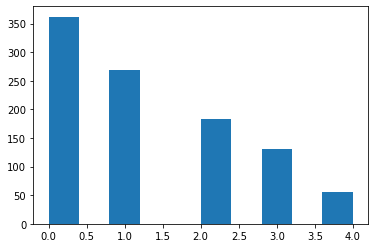

In [27]:
plt.hist(lst)